In [1]:
import os
import random
from PIL import Image
import tqdm
import torch
from torchmetrics import MetricCollection, Accuracy, AUROC
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Exploratory Data Analysis

In [3]:
# Defining the path to both folders
parasitized_path = '/kaggle/input/malaria/data/Parasitized'
uninfected_path = '/kaggle/input/malaria/data/Uninfected'

parasitized_images = [os.path.join(parasitized_path, x) for x in os.listdir(parasitized_path) if x.endswith('.png')]
uninfected_images = [os.path.join(uninfected_path, x) for x in os.listdir(uninfected_path) if x.endswith('.png')]

# Number of images for each class
print(f'Number of Parasitized images: {len(parasitized_images)}')
print(f'Number of Uninfected images: {len(uninfected_images)}')

Number of Parasitized images: 13779
Number of Uninfected images: 13779


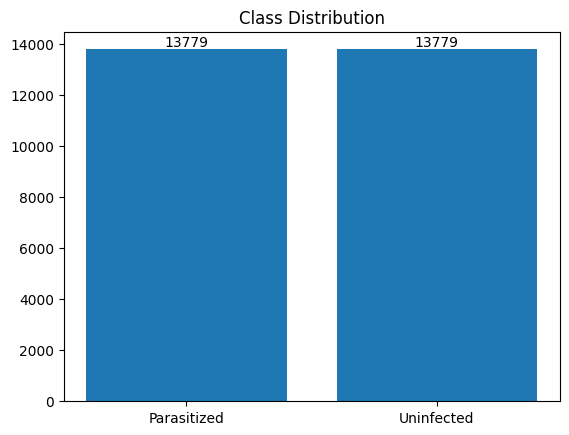

In [4]:
# Bar plot to show class distribution
bar = plt.bar(['Parasitized', 'Uninfected'], [len(parasitized_images), len(uninfected_images)])
plt.bar_label(bar, labels=[len(parasitized_images), len(uninfected_images)])
plt.title('Class Distribution')
plt.savefig('barplot.png')
plt.show()

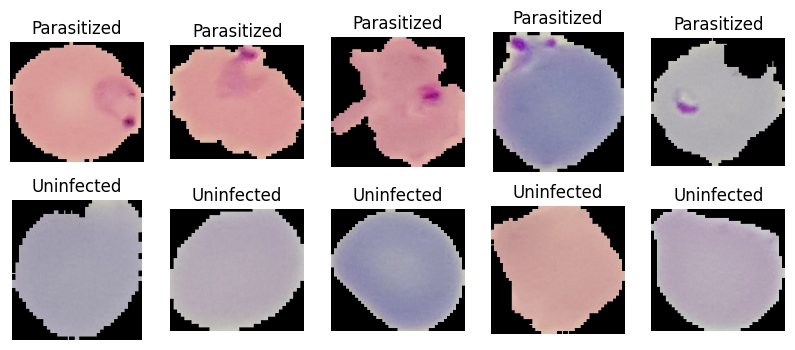

In [5]:
# Displaying 10 random images from both classes
random_parasitized = [(image, 'Parasitized') for image in random.sample(parasitized_images, 5)]
random_uninfected = [(image, 'Uninfected') for image in random.sample(uninfected_images, 5)]

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, images in enumerate(random_parasitized + random_uninfected):
    image = Image.open(images[0])
    row = i // 5
    col = i % 5
    axs[row, col].imshow(image)
    axs[row, col].set_title(images[1])
    axs[row, col].axis('off')
plt.show()

## Data Preprocessing

In [6]:
data_path = '/kaggle/input/malaria/data'
 
# Image transformations
transform = transforms.Compose([transforms.Resize((150, 150)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Splitting in to train, validation and test sets
data_set = ImageFolder(data_path, transform=transform)
train_set, val_set, test_set = torch.utils.data.random_split(data_set, [0.8, 0.1, 0.1])

# Creating DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, pin_memory=True, num_workers=2)

In [7]:
# Identifying class indices
data_set.class_to_idx

{'Parasitized': 0, 'Uninfected': 1}

In [8]:
# Print length of all datasets
len(train_set), len(val_set), len(test_set)

(22047, 2756, 2755)

In [9]:
# Check shape of processed data
for x, y in train_loader:
    print(x.shape, y.shape)
    print(x.min(), x.max())
    break

torch.Size([32, 3, 150, 150]) torch.Size([32])
tensor(-1.) tensor(0.8275)


## Train and Test Loops

In [10]:
# Capturing train and val metrics
train_hist = {'loss': [], 'acc': [], 'auroc': []}
val_hist = {'loss': [], 'acc': [], 'auroc': []}

def train(epoch):
    # Train Loop
    model.train()
    train_loss = 0.0
    for X, y in tqdm.tqdm(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X).squeeze()
            
        loss = criterion(output, y.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_metrics(output, y)
        
    train_loss /= len(train_loader)
    metrics = train_metrics.compute()
    train_hist['loss'].append(train_loss)
    train_hist['acc'].append(metrics['acc'].item())
    train_hist['auroc'].append(metrics['auroc'].item())
    print(f'Epoch: {epoch + 1}')
    print(f"Train Loss: {train_loss: .5f} Train Acc: {metrics['acc']: .4f} Train AUROC: {metrics['auroc']: .4f}")
    train_metrics.reset()
    
    # Val Loop
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
    
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            output = model(X).squeeze()
            
            loss = criterion(output, y.float())
            val_loss += loss.item()
            
            val_metrics(output, y)
        
        val_loss /= len(val_loader)
        metrics = val_metrics.compute() 
        val_hist['loss'].append(val_loss)
        val_hist['acc'].append(metrics['acc'].item())
        val_hist['auroc'].append(metrics['auroc'].item())
        print(f"Val Loss: {val_loss: .5f} Val Acc: {metrics['acc']: .4f} Val AUROC: {metrics['auroc']: .4f}")
        val_metrics.reset()

In [11]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0.0
    
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X).squeeze()
            
            loss = criterion(output, y.float())
            test_loss += loss.item()
            
            test_metrics(output, y)
        
        test_loss /= len(test_loader)
        metrics = test_metrics.compute() 
        print(f"Test Loss: {test_loss: .5f} Test Acc: {metrics['acc']: .4f} Test AUROC: {metrics['auroc']: .4f}")
        test_metrics.reset()

## Convolutional Neural Network

In [12]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(
                nn.Conv2d(3, 64, 3),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3),
                nn.ReLU(),
                nn.MaxPool2d(2))
        
        self.fc = nn.Sequential(
                nn.Linear(128 * 36 * 36, 64),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(32, 1))
        
    def forward(self, x):
        x = self.features(x)
        x = self.fc(x.view(x.size(0), -1))
        return x

## Training the CNN

In [13]:
model = MyCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_metrics = MetricCollection({
    'acc': Accuracy(task='binary'),
    'auroc': AUROC(task='binary')
}).to(device)

val_metrics = MetricCollection({
    'acc': Accuracy(task='binary'),
    'auroc': AUROC(task='binary')
}).to(device)

test_metrics = MetricCollection({
    'acc': Accuracy(task='binary'),
    'auroc': AUROC(task='binary')
}).to(device)

In [14]:
for epoch in range(5):
    train(epoch)

100%|██████████| 689/689 [01:39<00:00,  6.92it/s]

Epoch: 1
Train Loss:  0.36136 Train Acc:  0.8602 Train AUROC:  0.9338


Val Loss:  0.23449 Val Acc:  0.9340 Val AUROC:  0.9715


100%|██████████| 689/689 [00:46<00:00, 14.95it/s]

Epoch: 2
Train Loss:  0.20922 Train Acc:  0.9418 Train AUROC:  0.9728


Val Loss:  0.24696 Val Acc:  0.9361 Val AUROC:  0.9724


100%|██████████| 689/689 [00:45<00:00, 15.08it/s]

Epoch: 3
Train Loss:  0.19275 Train Acc:  0.9455 Train AUROC:  0.9770


Val Loss:  0.28831 Val Acc:  0.9245 Val AUROC:  0.9702


100%|██████████| 689/689 [00:45<00:00, 15.14it/s]

Epoch: 4
Train Loss:  0.17212 Train Acc:  0.9509 Train AUROC:  0.9802



/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Val Loss:  0.23337 Val Acc:  0.9419 Val AUROC:  0.9723


100%|██████████| 689/689 [00:46<00:00, 14.83it/s]

Epoch: 5
Train Loss:  0.15807 Train Acc:  0.9548 Train AUROC:  0.9829


Val Loss:  0.20927 Val Acc:  0.9467 Val AUROC:  0.9780


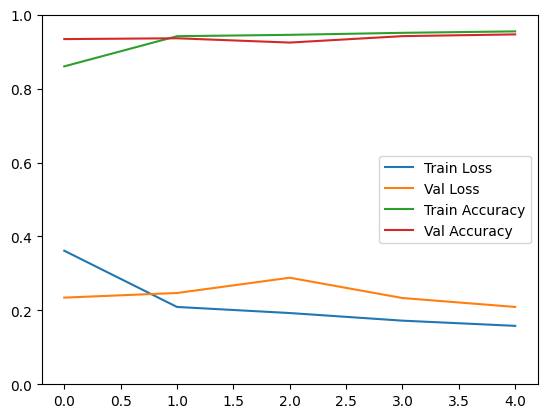

In [15]:
# Plotting the train and val metrics
plt.plot(train_hist['loss'], label='Train Loss')
plt.plot(val_hist['loss'], label='Val Loss')
plt.plot(train_hist['acc'], label='Train Accuracy')
plt.plot(val_hist['acc'], label='Val Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Saving and loading the model

In [16]:
torch.save(model.state_dict(), 'model_weights.pth')
model = MyCNN().to(device)
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

## Testing the CNN

In [17]:
test()

Test Loss:  0.14686 Test Acc:  0.9568 Test AUROC:  0.9852
